**Modelling**

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

import time

from dm4bem import read_epw, sol_rad_tilt_surf

HSP= 3 #m
h = 8 # W/(m²⋅K)

air = {'Conductivity': 0.026,              # W/(m·K)
       'Density': 1.2,                     # kg/m³
       'Specific heat': 1000,             # J/(kg·K)
       'Width': 0,                     # m (non spécifié)
       'Surface': 0}                   # m² (non spécifiée)

window = {'Conductivity': 1.015,           # W/(m·K)
          'Density': 2500,                 # kg/m³
          'Specific heat': 720,            # J/(kg·K)
          'Width': 0.05,                   # m
          'Surface': 6.57 * HSP}           # m²

entry_door = {'Conductivity': 0.15,        # W/(m·K)
              'Density': 520,              # kg/m³
              'Specific heat': 1600,       # J/(kg·K)
              'Width': 0.03,               # m
              'Surface': 1.4 * HSP}        # m²

small_door = {'Conductivity': 0.15,        # W/(m·K)
              'Density': 520,              # kg/m³
              'Specific heat': 1600,       # J/(kg·K)
              'Width': 0.03,               # m
              'Surface': 1.4 * HSP}        # m²

external_wall = {'Conductivity': 0.027,    # W/(m·K)
                 'Density': 55,            # kg/m³
                 'Specific heat': 1210,    # J/(kg·K)
                 'Width': 0.2,             # m
                 'Surface': 13.39 * HSP}   # m²
external_wall2 = {'Conductivity': 0.027,    # W/(m·K)
                 'Density': 55,            # kg/m³
                 'Specific heat': 1210,    # J/(kg·K)
                 'Width': 0.2,             # m
                 'Surface': 4.33 * HSP}   # m²

internal_wall = {'Conductivity': 0.058,    # W/(m·K)
                 'Density': 250,           # kg/m³
                 'Specific heat': 2100,    # J/(kg·K)
                 'Width': 0.08,            # m
                 'Surface': 3.28 * HSP}    # m²



wall = pd.DataFrame.from_dict({'external_wall': external_wall,
                               'external_wall2': external_wall2,
                               'internal_wall': internal_wall,
                               'small_door': small_door,
                               'entry_door':entry_door,
                               'window':window},
                              orient='index')
wall

# convection
Gconv = h * wall['Surface'].iloc[0]     # convection dans la salle jaune


# conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns=['Conductance'])

# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant

rho_air= 1.02
c_air=1005
S = 20.0    # m², wall surface area
#Ti = 24.0   # °C, inside air temperature
λ = 1.0     # W/(m·K), thermal conductivity
ho = 25.0   # W/(m²·K), outside convection coefficient
hi = 8.0    # W/(m²·K), outside convection coefficient
α = 0.70    # -, absorbtance of outdoor surface
E = 200.0   # W/m², solar irradiance on the outdoor surface

T0 = 12  # °C, neighbor air temperature
print("La température du voisinage est de:", T0, "°C")
T1 = 10   # °C, outside air temperature
print("La température extérieure est de:", T1, "°C")
T2 = 20 # °C, HVAC air temperature
print("La température en consigne est de:", T2,"°C")

Ufenetre= 4
Usmallporte=3.2
Uentryporte=1.6

ACH = 5
V= 96.09 #volume en m3
rho= 1.02 #de l'air à 20 degrés kg/m3
c= 1005 # J/kg/degrésC
K = 10000 #proportional gain of the HVAC
#qHVAC = K*(T2-Ti) #Heat flow rate injected by the HVAC
Φ1=1000





La température du voisinage est de: 12 °C
La température extérieure est de: 10 °C
La température en consigne est de: 20 °C


**System of algebraic-differential equations (DAE)**

In [185]:
# temperature nodes
θ = ['θ0', 'θ1', 'θ2', 'θ3', 'θ4', 'θ5']

# flow-rate branches
q = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10']

# Incidence matrix

A = np.zeros([11, 6])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = 1, -1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = 1, -1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = 1, -1    # branch 3: node 2 -> node 3
A[4, 3] = 1    # branch 4: node 3 -> node 4
A[5, 2], A[5, 0] = -1, 1    # branch 5: node 4 -> node 5
A[6, 5], A[6, 4] = 1, -1    # branch 6: node 4 -> node 6
A[7, 4]= 1    # branch 7: node 5 -> node 6
A[8, 0] = 1                 # branch 8: -> node 7
A[9, 0], A[9,5]= 1,-1    # branch 9: node 5 -> node 7
A[10, 0] = 1                # branch 10: -> node 6

# Conductance matrix
G = np.array(np.hstack(
    [Ufenetre* wall['Surface'].iloc[5] + rho_air*c_air*ACH*V/3600,
     2 * G_cd['internal_wall'], 2 * G_cd['internal_wall'],
     2 * G_cd['external_wall2'], 2 * G_cd['external_wall2'],
     Usmallporte*wall['Surface'].iloc[3],
     2 * G_cd['external_wall'], 2 * G_cd['external_wall'],
     Uentryporte*wall['Surface'].iloc[4],
     Gconv,
     K]))
Diag_G =np.diag(G)

#Capacity matrix
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
pd.DataFrame(C, columns=['Capacity'])

C['Air'] = air['Density'] * air['Specific heat'] * V
pd.DataFrame(C, columns=['Capacity'])

C = np.array([0, C['internal_wall'], 0, C['external_wall2'], C['external_wall'], 0]) #on n' a pas mis la capacité thermique de l'air dans le vecteur C

# Temperature source vector
b = np.array([T1, 0,0,0, T0, 0, 0, T0, T0, 0, T2])

# Flow-rate source vector
f = pd.Series([0, 0, 0, 0, 0, 'Φ1'],
              index=θ)

# Output vector
y = np.zeros(6)         # nodes
y[[0]] = 1
y[[2]] = 1         # nodes (temperatures) of interest
pd.DataFrame(y, index=θ)

# thermal circuit
A = pd.DataFrame(A, index=q, columns=θ)
G = pd.Series(G, index=q)
C = pd.Series(C, index=θ)
b = pd.Series(b, index=q)
f = pd.Series(f, index=θ)
y = pd.Series(y, index=θ)

TC = {"A": A,
      "G": G,
      "C": C,
      "b": b,
      "f": f,
      "y": y}



**State-space representation**

On pose toutes les températures des voisins (T0) égales à 10°C

In [186]:
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
print(Cs)
imposed_time_step = True
Δt = 498    # s, imposed time step

bss = np.zeros(11)        # temperature sources b for steady state
bss[[4, 7, 8]] = 10      # neighboor temperature =10
bss[[10]] = 20            # indoor set-point temperature

fss = np.zeros(6)         # flow-rate sources f for steady state


          θ1        θ3        θ4
θ0  0.001990  0.000147  0.001023
θ2  0.457941  0.112422  0.000441


Steady-state from differential algebraic equations (DAE)

In [187]:

##Steady-state from differential algebraic equations (DAE)


diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

θ = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θ = {np.around(θ, 2)} °C')




θ = [19.57 19.19 18.81 14.41 14.7  19.41] °C


Steady-state from state-space representation


In [188]:
##Steady-state from state-space representation

bT = np.array([T1, T0, T0, T0, T2])
fQ = np.array([Φ1])
uss = np.hstack([bT, fQ])           # input vector for state space
print(f'uss = {uss}')



inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yss = (-Cs @ inv_As @ Bs + Ds) @ uss
yss = float(yss.values[0])
print(f'yss = {yss:.2f} °C')



uss = [  10   12   12   12   20 1000]
yss = 19.87 °C


Error between the steady-state values obtained from the system of DAE

In [189]:
##Error between the steady-state values obtained from the system of DAE

print(f'Error between DAE and state-space: {abs(θ[0] - yss):.2e} °C')


Error between DAE and state-space: 3.10e-01 °C


**Eigenvalues analysis**

Time step, Duration and Settling time

In [190]:
# Eigenvalues analysis
λ = np.linalg.eig(As)[0]        # eigenvalues of matrix As

# time step
Δtmax = 2 * min(-1. / λ)    # max time step for stability of Euler explicit
dm4bem.print_rounded_time('Δtmax', Δtmax)

if imposed_time_step:
    dt = Δt
else:
    dt = dm4bem.round_time(Δtmax)
dm4bem.print_rounded_time('dt', dt)


if dt < 10:
    raise ValueError("Time step is too small. Stopping the script.")

# settling time
t_settle = 4 * max(-1 / λ)
dm4bem.print_rounded_time('t_settle', t_settle)

# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)


Δtmax = 36171 s = 10.0 h
dt = 498 s = 8.3 min
t_settle = 110598 s = 30.7 h
duration = 111600 s = 31.0 h


In [191]:
#Step response to outdoor temperature


# Vecteur de temps
n = int(np.floor(duration / dt))
time = pd.date_range(start="2000-01-01 00:00:00", periods=n, freq=f"{int(dt)}s")

# Initialisation des données
T0 = 12 * np.ones(n)
T1 = 10 * np.ones(n)
T2 = 20 * np.ones(n)
Φ1 = 1000 * np.ones(n)

# Création du DataFrame
data = {
    'q0': T1,
    'q4': T0,
    'q7': T0,
    'q8': T0,
    'q10': T2,
    'θ5': T1  # ou T0, selon votre choix
}
input_data_set = pd.DataFrame(data, index=time)


# inputs in time from input_data_set
u = input_data_set[us.index]
print(u)

#u = dm4bem.inputs_in_time(us, input_data_set)

                       q0    q4    q7    q8   q10    θ5
2000-01-01 00:00:00  10.0  12.0  12.0  12.0  20.0  10.0
2000-01-01 00:08:18  10.0  12.0  12.0  12.0  20.0  10.0
2000-01-01 00:16:36  10.0  12.0  12.0  12.0  20.0  10.0
2000-01-01 00:24:54  10.0  12.0  12.0  12.0  20.0  10.0
2000-01-01 00:33:12  10.0  12.0  12.0  12.0  20.0  10.0
...                   ...   ...   ...   ...   ...   ...
2000-01-02 06:17:42  10.0  12.0  12.0  12.0  20.0  10.0
2000-01-02 06:26:00  10.0  12.0  12.0  12.0  20.0  10.0
2000-01-02 06:34:18  10.0  12.0  12.0  12.0  20.0  10.0
2000-01-02 06:42:36  10.0  12.0  12.0  12.0  20.0  10.0
2000-01-02 06:50:54  10.0  12.0  12.0  12.0  20.0  10.0

[224 rows x 6 columns]


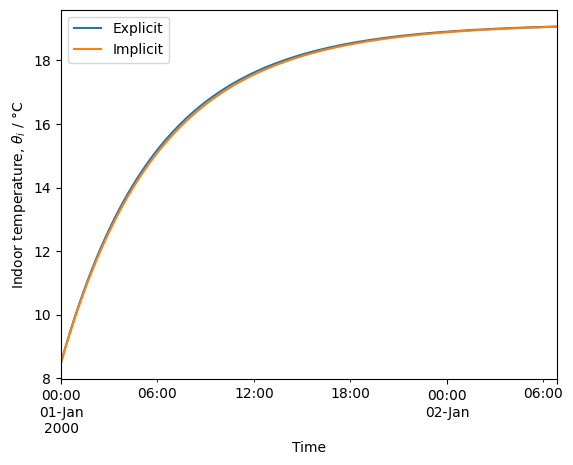

Steady-state indoor temperature obtained with:
- DAE model: 19.5650 °C
- state-space model: 19.8746 °C
- steady-state response to step input: 19.0690 °C


In [192]:
#Time integration

# Initial conditions
θ_exp = pd.DataFrame(index=u.index)     # empty df with index for explicit Euler
θ_imp = pd.DataFrame(index=u.index)     # empty df with index for implicit Euler

θ0 = 0.0                    # initial temperatures
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])


# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T
# Select the desired output column (e.g., 'θ0')
y_exp_theta2 = y_exp['θ2']
y_imp_theta2 = y_imp['θ2']


# Combine only the selected output for Explicit and Implicit results for plotting
y = pd.concat([y_exp_theta2, y_imp_theta2], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)

# Plot the results
ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / °C')
# Ensure dt and Δtmax are defined if you want to include them in the title
# ax.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {Δtmax:.0f} s')
plt.show()

print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θ[0]):.4f} °C')
print(f'- state-space model: {float(yss):.4f} °C')
print(f'- steady-state response to step input: \
{y_exp["θ2"].tail(1).values[0]:.4f} °C')

**Discussion**

Influence of time step

**Weather**

In [193]:
start_date = '02-01 12:00:00'
end_date = '02-07 18:00:00'
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

# Temperature sources
T1 = weather['temp_air']

# total solar irradiance
external_wall = pd.read_csv('./bldg/external_wall.csv')
w0 = external_wall[external_wall['ID'] == 'w0']

surface_orientation = {'slope': w0['β'].values[0],
                       'azimuth': w0['γ'].values[0],
                       'latitude': 45}

rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, w0['albedo'].values[0])

Etot = rad_surf.sum(axis=1)

S_g = 9         # m², surface area of glass

# solar radiation absorbed by the outdoor surface of the wall
Φo = w0['α1'].values[0] * w0['Area'].values[0] * Etot


# solar radiation absorbed by the indoor surface of the wall
Φi = τ_gSW * w0['α0'].values[0] * S_g * Etot

# solar radiation absorbed by the glass
Φa = α_gSW * S_g * Etot



2000-02-01 12:00:00 	start date
2000-02-07 18:00:00 	end date


**Schedules**

In [194]:
# indoor air temperature set-point
T2 = pd.Series(20, index=T1.index)

Ti_day, Ti_night = 20, 16

T2 = pd.Series(
    [Ti_day if 6 <= hour <= 22 else Ti_night for hour in T1.index.hour],
    index=T1.index)

# Ensure T0 and Φ1 have the same index as the other variables
T0 = pd.Series(12, index=T1.index)
Φ1 = pd.Series(1000, index=T1.index)

# Input data set
input_data_set = pd.DataFrame({'T0': T0, 'T1': T1, 'T2': T2, 'Φ1': Φ1,
                               'Etot': Etot})
input_data_set.to_csv('./input_data_set.csv')

**Simulation: perfect controller**

In [195]:
controller = True

neglect_air_capacity = True
neglect_glass_capacity = True

explicit_Euler = True

imposed_time_step = False
Δt = 3600    # s, imposed time step

# MODEL

# by default TC['G']['q11'] = 0 # Kp -> 0, no controller (free-floating
if controller:
    TC['G']['q11'] = K     # G11 = Kp, conductance of edge q11
                            # Kp -> ∞, almost perfect controller
if neglect_air_capacity:
    TC['C']['θ6'] = 0       # C6, capacity of vertex θ6 (air)
if neglect_glass_capacity:
    TC['C']['θ7'] = 0       # C7, capacity of vertex θ7 (glass)


λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dt = dm4bem.round_time(dtmax)

if imposed_time_step:
    dt = Δt

dm4bem.print_rounded_time('dt', dt)

dt = 21600 s = 6.0 h


**Input data set**

In [196]:
# Flow-rate sources from f (in order of node index): θ5 (Φ1)

# The actual mapping depends on the internal logic of dm4bem.tc2ss.
# However, if the state-space inputs correspond to the non-zero entries
# of the b and f vectors in that order, the mapping should be:
us = pd.Series(['T1', 'T0', 'T0', 'T0', 'T2', 'Φ1'],
               index=[0, 1, 2, 3, 4, 5]) # Assuming 6 state-space inputs

# INPUT DATA SET
# ==============
input_data_set = pd.read_csv('./input_data_set.csv',
                             index_col=0,
                             parse_dates=True)
input_data_set
# print(u) # This print statement should be removed or moved after u is defined in this cell

input_data_set = input_data_set.resample(
    str(dt) + 's').interpolate(method='linear')
input_data_set.head()

# Input vector in time from input_data_set
# Now, dm4bem.inputs_in_time should look up the correct columns in input_data_set
# using the values in the manually corrected us Series.
u = dm4bem.inputs_in_time(us, input_data_set)
u.head()


,0,1,2,3,4,5
2000-02-01 12:00:00+01:00,10.0,12,12,12,20,1000
2000-02-01 18:00:00+01:00,8.0,12,12,12,20,1000
2000-02-02 00:00:00+01:00,7.3,12,12,12,16,1000
2000-02-02 06:00:00+01:00,6.7,12,12,12,20,1000
2000-02-02 12:00:00+01:00,11.8,12,12,12,20,1000


**Initial conditions**

In [202]:
# Initial conditions
θ0 = 20.0                   # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0
for k in range(u.shape[0] - 1):
    # Calculer le nouveau vecteur d'état (résultat est un tableau NumPy)
    new_state_np = (I + dt * As) @ θ.iloc[k].values + dt * Bs @ u.iloc[k].values

    # Convertir le tableau NumPy en une Série Pandas avec les mêmes noms de colonnes que θ
    new_state_series = pd.Series(new_state_np, index=θ.columns)

    # Assigner la Série au DataFrame θ à la ligne k+1
    θ.iloc[k + 1] = new_state_series


# Calculer le résultat du modèle d'espace d'état (tableau NumPy)
y_np = (Cs.values @ θ.T.values + Ds.values @  u.T.values).T

# Convertir le tableau NumPy en DataFrame Pandas en utilisant les noms de colonnes de Cs
y = pd.DataFrame(y_np, index=u.index, columns=Cs.index)


Kp = K
S = 9                   # m², surface area of the toy house
q_HVAC = Kp * (u.loc[:, 5] - y['θ0']) / S  # W/m²
y['θ0']

,θ0
2000-02-01 12:00:00+01:00,19.878799
2000-02-01 18:00:00+01:00,19.833675
2000-02-02 00:00:00+01:00,15.917259
2000-02-02 06:00:00+01:00,19.795055
2000-02-02 12:00:00+01:00,19.913040
2000-02-02 18:00:00+01:00,19.857551
2000-02-03 00:00:00+01:00,15.952955
2000-02-03 06:00:00+01:00,19.811916
2000-02-03 12:00:00+01:00,19.896252
2000-02-03 18:00:00+01:00,19.853299


*PLOT*

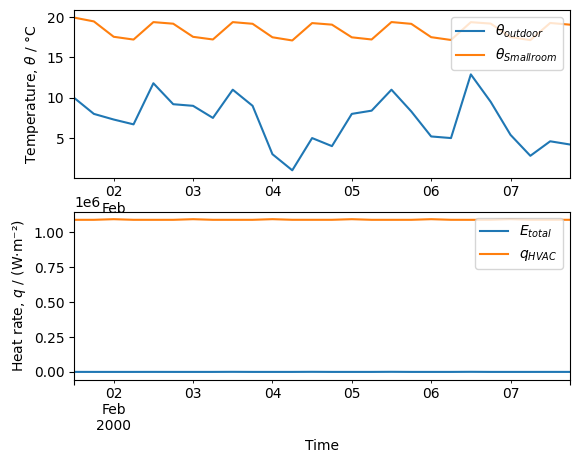

In [198]:
data = pd.DataFrame({'T1': input_data_set['T1'],
                     'θ2': y['θ2'],
                     'Etot': input_data_set['Etot'],
                     'q_HVAC': q_HVAC})

fig, axs = plt.subplots(2, 1)
data[['T1', 'θ2']].plot(ax=axs[0],
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')

axs[0].legend(['$θ_{outdoor}$', '$θ_{Small room}$'],
              loc='upper right')

data[['Etot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / (W·m⁻²)')
axs[1].set(xlabel='Time')
axs[1].legend(['$E_{total}$', '$q_{HVAC}$'],
              loc='upper right')
plt.show();

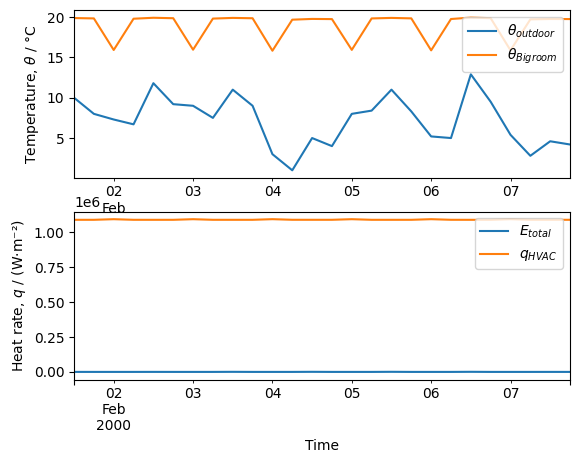

In [199]:
data = pd.DataFrame({'T1': input_data_set['T1'],
                     'θ0': y['θ0'],
                     'Etot': input_data_set['Etot'],
                     'q_HVAC': q_HVAC})

fig, axs = plt.subplots(2, 1)
data[['T1', 'θ0']].plot(ax=axs[0],
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')

axs[0].legend(['$θ_{outdoor}$', '$θ_{Big room}$'],
              loc='upper right')

data[['Etot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / (W·m⁻²)')
axs[1].set(xlabel='Time')
axs[1].legend(['$E_{total}$', '$q_{HVAC}$'],
              loc='upper right')
plt.show();

**DISCUSSION**

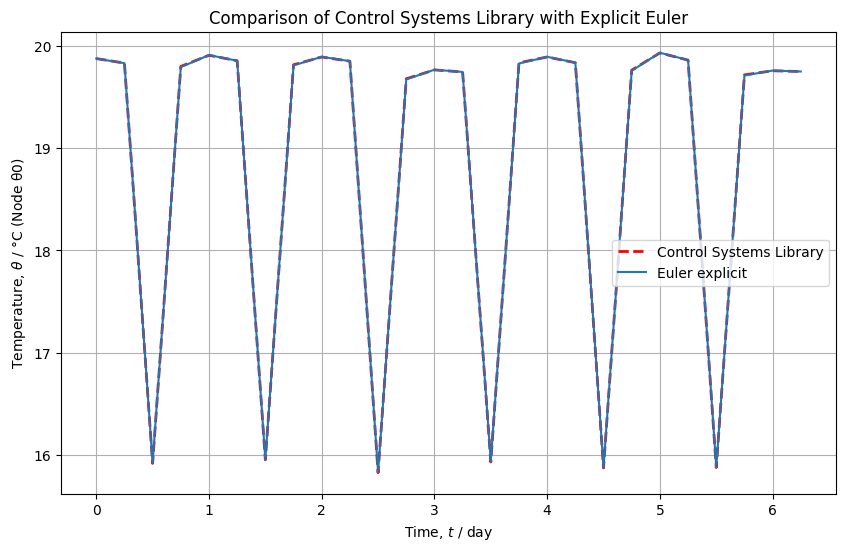

Duration for Control Systems Library: 0.02 seconds
Duration for Euler explict:           0.04 seconds


In [225]:
import time


sys = ctrl.ss(As.values, Bs.values, Cs.values, Ds.values)


θ0_sim_np = θ0



u_np_ctrl = u.values.T       # inputs in time (transposés pour la librairie control)


t_np = (u.index - u.index.min()).total_seconds().values


start_time = time.time()


t_ctrl, yout_ctrl, xout_ctrl = ctrl.input_output_response(sys, T=t_np, U=u_np_ctrl, X0=θ0_sim_np, return_x=True)

end_time = time.time()
duration_1 = end_time - start_time

start_time = time.time()

# Euler explicit
θ0 = 20.0                   # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0
for k in range(u.shape[0] - 1):
    # Calculer le nouveau vecteur d'état (résultat est un tableau NumPy)
    new_state_np = (I + dt * As) @ θ.iloc[k].values + dt * Bs @ u.iloc[k].values

    # Convertir le tableau NumPy en une Série Pandas avec les mêmes noms de colonnes que θ
    new_state_series = pd.Series(new_state_np, index=θ.columns)

    # Assigner la Série au DataFrame θ à la ligne k+1
    θ.iloc[k + 1] = new_state_series


# Calculer le résultat du modèle d'espace d'état (tableau NumPy)
y_np = (Cs.values @ θ.T.values + Ds.values @  u.T.values).T

# Convertir le tableau NumPy en DataFrame Pandas en utilisant les noms de colonnes de Cs
y = pd.DataFrame(y_np, index=u.index, columns=Cs.index)


end_time = time.time()
duration_2 = end_time - start_time

fig, axs = plt.subplots(figsize=(10, 6))

output_name_to_plot = 'θ0'


axs.plot(t_ctrl / 3600 / 24, yout_ctrl[idx_output_plot, :], label='Control Systems Library',
         linestyle='--', color='red', linewidth=2, marker='', markersize=4)


axs.plot((y.index - y.index.min()).total_seconds().values / 3600 / 24, # Temps pour Euler
        y[output_name_to_plot].values, label='Euler explicit') # Valeurs de la colonne sélectionnée

axs.set(xlabel='Time, $t$ / day',
        ylabel=f'Temperature, $θ$ / °C (Node {output_name_to_plot})', # Indiquer quel nœud est tracé
        title='Comparison of Control Systems Library with Explicit Euler')
axs.grid(True)
axs.legend()
plt.show()

# Print the comparison of durations
print(f"Duration for Control Systems Library: {duration_1:.2f} seconds")
print(f"Duration for Euler explict:           {duration_2:.2f} seconds")